In [1]:
!pip install -q -U --user lightgbm
!pip install -q --user  hypergbm

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv
/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv


In [3]:
pd.set_option('display.max.columns',50)
pd.set_option('display.max.rows',50)

In [4]:
df_orig = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
df_train= pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test= pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

df_orig.shape,df_train.shape,df_test.shape

((2111, 17), (20758, 18), (13840, 17))

In [5]:
df_orig.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
df_train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
target = 'NObeyesdad'


# pre-training

In [8]:
from hypernets.core.search_space import Choice,Int
from hypergbm.search_space import GeneralSearchSpaceGenerator
from hypergbm import make_experiment
from sklearn.metrics import accuracy_score, make_scorer

In [9]:
exp0 = make_experiment(df_train.copy(), target=target, 
                  reward_metric='accuracy', 
                  data_adaption=False,
                  max_trials=30,
                  random_state=123,
                 )
# est0 = exp0.run()

In [10]:
# from sklearn.metrics import classification_report

# X0 = df_train.copy()
# y0 = X0.pop(target)
# y_pred0 = est0.predict(X0)

# print(classification_report(y0, y_pred0, digits=5))

In [11]:
idx_ol = df_train[(df_train[target]=='Overweight_Level_I') | (df_train[target]=='Overweight_Level_II') ].index
df_ol = df_train.iloc[idx_ol,:]
df_ol.shape

(4949, 18)

In [12]:
df_train_w = pd.concat([
    df_train.drop('id',axis=1),
    df_orig, #.sample(frac=0.5,random_state=123),
    df_ol.drop('id',axis=1).sample(frac=0.5,random_state=123),
]).sample(frac=1.0,random_state=123).reset_index(drop=True)

df_train_w

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,19.216380,1.537770,42.324558,no,yes,3.000000,1.000000,Frequently,no,1.568035,no,0.000000,0.322666,Sometimes,Public_Transportation,Insufficient_Weight
1,Female,26.000000,1.641601,111.933152,yes,yes,3.000000,3.000000,Sometimes,no,2.737353,no,0.000000,0.123861,Sometimes,Public_Transportation,Obesity_Type_III
2,Male,34.000000,1.690000,67.000000,yes,yes,2.000000,3.000000,Always,no,2.000000,no,0.000000,2.000000,Sometimes,Public_Transportation,Normal_Weight
3,Female,19.665881,1.741193,131.529267,yes,yes,3.000000,3.000000,Sometimes,no,2.474518,no,1.584716,0.925843,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,21.106056,1.611000,70.000000,no,yes,2.000000,3.000000,no,no,3.000000,no,0.923428,0.220029,Sometimes,Public_Transportation,Overweight_Level_I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25338,Male,18.000000,1.670000,70.000000,no,yes,3.000000,3.000000,Frequently,no,2.000000,no,1.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
25339,Female,21.687409,1.604697,68.016472,yes,yes,1.901611,3.266501,no,no,2.926995,no,0.985872,0.307982,Sometimes,Public_Transportation,Overweight_Level_I
25340,Female,26.000000,1.611462,111.939671,yes,yes,3.000000,3.000000,Sometimes,no,2.609188,no,0.007050,0.228598,Sometimes,Public_Transportation,Obesity_Type_III
25341,Male,31.630054,1.835381,128.828122,yes,yes,2.880759,3.000000,Sometimes,no,2.471033,no,0.170480,0.000000,Sometimes,Public_Transportation,Obesity_Type_II


# training

### Input Data

,X_train.shape,y_train.shape,X_eval.shape,y_eval.shape,X_test.shape,Task
0,"(25343, 16)","(25343,)",None,None,None,multiclass(7)


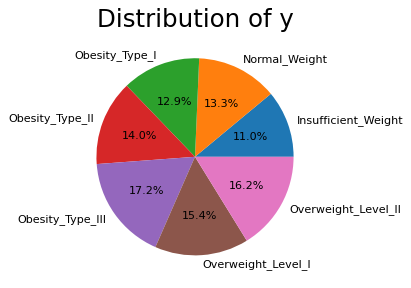

## Data Clean

### Initliazed parameters

,key,value
0,cv,True
1,data_cleaner_args,"{'nan_chars': None, 'correct_object_dtype': Tr..."
2,name,data_clean
3,train_test_split_strategy,None


### Fitted parameters

,key,value
0,input_features,"[Gender, Age, Height, Weight, family_history_w..."
1,selected_features,"[Gender, Age, Height, Weight, family_history_w..."
2,unselected_features,[]
3,X_train.shape,"(25343, 16)"
4,y_train.shape,"(25343,)"
5,X_eval.shape,None
6,y_eval.shape,None
7,X_test.shape,None
8,unselected_reason,{}
9,kept/dropped feature count,16/0


### Elapsed

* 0.208 seconds

## Space Searching

### Initliazed parameters

,key,value
0,cv,True
1,name,space_searching
2,num_folds,3


#### Experiment Settings:

HyperGBM(searcher=MCTSSearcher(space_fn=MySearchSpace(kwargs=None, early_stopping_rounds=30), optimize_direction='max'), callbacks=[EarlyStoppingCallback(max_no_improvement_trials=25, mode='max', time_limit=7199.790232419968), NotebookCallback(), ProgressiveCallback(), FitCrossValidationCallback()], reward_metric=<function my_acc at 0x7d348000eef0>, task='multiclass', discriminator=OncePercentileDiscriminator(percentile=50, history=TrialHistory(direction='max'), optimize_direction='max'))

,X,y,X_eval,y_eval,cv,num_folds,max_trials,fit_kwargs
0,"(25343, 16)","(25343,)",None,None,True,3,100,()


#### Trials Summary:

,Trial No.,Previous reward,Best trial,Best reward,Total elapsed,Valid trials,Max trials
0,72,0.903347,40,[0.9091945060876867],1381.047904,60,100


#### Best Trial:

key,value
signature,b1d21023553aad8264d20ee40d1c252c
vectors,"[0, 2, 1, 30, 1, 290, 3, 2, 3, 0, 1, 2]"
0-estimator_options.hp_or,0
1-numeric_imputer_0.strategy,constant
2-numeric_or_scaler_0.hp_or,1
3-Module_LightGBMEstimator_1.min_data_in_leaf,30
4-Module_LightGBMEstimator_1.boosting_type,goss
5-Module_LightGBMEstimator_1.num_leaves,290
6-Module_LightGBMEstimator_1.max_depth,10
7-Module_LightGBMEstimator_1.learning_rate,0.1


#### Top trials:

,Trial No.,Reward,Elapsed,Space Vector
0,40,[0.9091945060876867],19.224409,"[0, 2, 1, 30, 1, 290, 3, 2, 3, 0, 1, 2]"
1,54,[0.9083548251664367],17.098723,"[0, 3, 4, 40, 1, 455, 3, 2, 0, 1, 2, 0]"
2,53,[0.9075151442451869],17.790675,"[0, 3, 3, 10, 1, 490, 2, 2, 3, 0, 0, 0]"
3,35,[0.9073951898278654],26.522200,"[2, 0, 2, 2, 2, 465, 0]"
4,73,[0.9071252923888922],16.470078,"[2, 2, 1, 2, 3, 350, 3]"


search:   0%|          | 0/100 [00:00<?, ?it/s]

fit_cross_validation:   0%|          | 0/3 [00:00<?, ?it/s]

### Fitted parameters

,key,value
0,input_features,"[Gender, Age, Height, Weight, family_history_w..."
1,best_reward,[0.9091945060876867]
2,history,"TrialHistory(direction='max', size=73, succeed..."


### Elapsed

* 1381.142 seconds

## Final Ensemble

### Initliazed parameters

,key,value
0,ensemble_size,20
1,name,final_ensemble
2,scorer,make_scorer(my_acc)


### Fitted parameters

,0,1
0,weights,"[0.15, 0.0, 0.1, 0.0, 0.0, 0.05, 0.0, 0.1, 0.0..."
1,scores,"[0.9091945060876867, 0.9121633779163918, 0.913..."
2,best_stack,"[0, 9, 19, 7, 13, 11, 2, 19, 13, 5, 0, 19, 9, ..."
3,hits,"{0: 3, 9: 3, 19: 3, 7: 2, 13: 2, 11: 4, 2: 2, ..."
4,ensemble_size,20


### Elapsed

* 26.363 seconds

In [13]:
from hypernets.core import randint

class MySearchSpace(GeneralSearchSpaceGenerator):
    def __init__(self, enable_lightgbm=True, enable_xgb=True, enable_catboost=False, enable_histgb=True,**kwargs): 
        super().__init__(enable_lightgbm=enable_lightgbm, 
                         enable_xgb=enable_xgb, 
                         enable_catboost=enable_catboost, 
                         enable_histgb=enable_histgb,
                         **kwargs)

    @property
    def default_lightgbm_init_kwargs(self):
        return {
            'objective': 'multiclass',
            'num_class':7,
#             'n_estimators': Choice([100, 200, 300, 500]),
            'n_estimators': Choice([100, 200, 300, 500]),
            'boosting_type': Choice(['gbdt', 'goss']), #'dart',
            'num_leaves': Int(15, 513, 5),
            'learning_rate': Choice([0.01, 0.03, 0.1, 0.3]), #[0.001, 0.01, 0.03, 0.5, 0.1]
#             'max_depth': Int(3,15,2), #Choice([3, 5, 7, 10]),
            'max_depth': Choice([3, 5, 7, 10]),
            'reg_alpha': Choice([0.001, 0.01, 0.1, 1, 10, 100]),
            'reg_lambda': Choice([0.001, 0.01, 0.1, 0.5, 1]),
#             'feature_fraction': Choice([0.8, 1.0]),
            'subsample':Choice([0.95,1.0]),
            'min_data_in_leaf': Int(10, 50, 10),
            'random_state': randint(),
            'class_balancing': None,
        }

    @property
    def default_xgb_init_kwargs(self):
        return {
            'max_depth': Choice([3, 5, 7, 10]),
            'n_estimators': Choice([200, 300]),
            'learning_rate': Choice([0.001, 0.01, 0.5, 0.1]),
            'min_child_weight': Choice([1, 5, 10]),
            'gamma': Choice([0.5, 1, 1.5, 2, 5]),
            'reg_alpha': Choice([0.001, 0.01, 0.1, 1, 10, 100]),
            'reg_lambda': Choice([0.001, 0.01, 0.1, 0.5, 1]),
            'random_state': randint(),
            'class_balancing': None,
        }

def my_acc(y_true, y_preds):
    sample_weight = np.where((y_true == 'Overweight_Level_I') | (y_true == 'Overweight_Level_II'), 2.0, 1.0)
    return accuracy_score(y_true, y_preds, sample_weight=sample_weight)


my_scorer = make_scorer(my_acc, greater_is_better=True, needs_proba=False)
search_space = MySearchSpace(early_stopping_rounds=30)

exp = make_experiment(df_train_w.copy(),target=target, 
                  #reward_metric='accuracy', 
                  reward_metric=my_acc, scorer=my_scorer,
                  data_adaption=False,
                  max_trials=100,
                  cv=True, num_folds=3,
                  search_space=search_space,
                  searcher='mcts',
                  early_stopping_rounds=25,
                  early_stopping_time_limit=7200,
                  ensemble_size=20,
                  random_state=335,
                 )
est = exp.run()

In [14]:
df_t = exp.hyper_model_.history.to_df(True)
df_t['reward'] = df_t['reward'].apply(lambda r: r[0] if isinstance(r,list) else r)
df_t.sort_values('reward',ascending=False).head(30).T

,39,53,52,34,72,44,43,30,60,64,58,37,33,51,45,66,31,71,50,49,57,36,65,17,69,70,25,12,22,21
trial_no,40,54,53,35,73,45,44,31,61,65,59,38,34,52,46,67,32,72,51,50,58,37,66,18,70,71,26,13,23,22
succeeded,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
reward,0.909195,0.908355,0.907515,0.907395,0.907125,0.906975,0.906885,0.906795,0.906675,0.906556,0.906076,0.905956,0.905026,0.904756,0.903587,0.903527,0.903467,0.903347,0.903107,0.902837,0.901967,0.901787,0.901697,0.900708,0.900258,0.900138,0.899628,0.899418,0.898069,0.897679
elapsed,19.224409,17.098723,17.790675,26.5222,16.470078,14.917369,40.777293,15.708908,24.641228,53.119744,16.230608,15.79653,32.460023,22.618932,11.264813,10.001766,27.249851,24.417253,9.937575,13.220607,9.612542,13.648145,20.366073,22.771576,10.784268,24.433761,38.820247,9.408128,27.957517,51.754748
scores,{'my_acc': 0.9091945060876867},{'my_acc': 0.9083548251664367},{'my_acc': 0.9075151442451869},{'my_acc': 0.9073951898278654},{'my_acc': 0.9071252923888922},{'my_acc': 0.9069753493672404},{'my_acc': 0.9068853835542494},{'my_acc': 0.9067954177412583},{'my_acc': 0.9066754633239369},{'my_acc': 0.9065555089066155},{'my_acc': 0.9060756912373298},{'my_acc': 0.9059557368200084},{'my_acc': 0.9050260900857674},{'my_acc': 0.9047561926467942},{'my_acc': 0.9035866370779104},{'my_acc': 0.9035266598692497},{'my_acc': 0.9034666826605889},{'my_acc': 0.9033467282432676},{'my_acc': 0.9031068194086247},{'my_acc': 0.9028369219696515},{'my_acc': 0.9019672524440713},{'my_acc': 0.9017873208180891},{'my_acc': 0.9016973550050981},{'my_acc': 0.9007077310621964},{'my_acc': 0.9002579019972411},{'my_acc': 0.9001379475799196},{'my_acc': 0.8996281413063036},{'my_acc': 0.8994182210759911},{'my_acc': 0.8980687338811252},{'my_acc': 0.8976788820248306}
oof,"[[0.9994162703547032, 0.000225215391268942, 2....","[[0.9984954241803998, 0.0007412305830288662, 2...","[[0.9986997338653673, 0.0005361022048359516, 3...","[[0.999973436760387, 7.536832358160962e-06, 1....","[[0.9998169202657415, 2.009110221956297e-05, 3...","[[0.999409637418855, 0.00018976105294836996, 2...","[[0.9999159230355263, 1.64592256840161e-05, 5....","[[0.999855362835984, 2.5494262054915166e-05, 3...","[[0.9986191274701464, 0.00031266143243683454, ...","[[0.9998302490792891, 3.039299669445961e-05, 1...","[[0.9998719334013093, 5.238021056151023e-05, 2...","[[0.9996845712923415, 4.382726913656098e-05, 5...","[[0.9998563752797791, 3.027054312560638e-05, 9...","[[0.9997821595916738, 1.1996027894427895e-05, ...","[[0.9997209027113735, 1.4993654140430332e-05, ...","[[0.9999980195741095, 2.0051432528912179e-07, ...","[[0.9980975441187708, 0.0004951674611523137, 2...","[[0.9987464670133496, 0.0006879576725261155, 1...","[[0.9996626838665663, 0.0003155902838965516, 4...","[[0.9999984177959385, 2.1077347717858826e-07, ...","[[0.9998717681618519, 1.3738975091890682e-06, ...","[[0.9996082319787114, 0.0001667391981167917, 1...","[[0.9999986080312531, 2.013763599829316e-07, 1...","[[0.9977546216810715, 0.0014311177087871026, 1...","[[0.9999296899241087, 9.700029419108973e-07, 2...","[[0.9986747017529981, 0.000705938636638477, 2....","[[0.9963367432258284, 0.002326666813767863, 0....","[[0.9977371196184899, 0.0005209626536167223, 0...","[[0.9986466888722074, 0.0007256790098290789, 7...","[[0.9961627452424616, 0.002171663577264415, 3...."
oof_scores,"[{'my_acc': 0.9135057212361474}, {'my_acc': 0....","[{'my_acc': 0.9125146409586449}, {'my_acc': 0....","[{'my_acc': 0.9144067033066042}, {'my_acc': 0....","[{'my_acc': 0.9123344445445536}, {'my_acc': 0....","[{'my_acc': 0.9116136588881881}, {'my_acc': 0....","[{'my_acc': 0.9119740517163708}, {'my_acc': 0....","[{'my_acc': 0.9114334624740967}, {'my_acc': 0....","[{'my_acc': 0.9100819893684116}, {'my_acc': 0....","[{'my_acc': 0.9098116947472745}, {'my_acc': 0....","[{'my_acc': 0.9126047391656906}, {'my_acc': 0....","[{'my_acc': 0.9132354266150103}, {'my_

In [15]:
em = est.steps[-1][-1]
list(zip(em.weights_,em.estimators))

[(0.15,
  HyperGBMEstimator(task=multiclass, reward_metric=<function my_acc at 0x7d348000eef0>, cv=True,
  data_pipeline: DataFrameMapper(df_out=True,
                  df_out_dtype_transforms=[(ColumnSelector(include:['object', 'string']),
                                            'int')],
                  features=[(ColumnSelector(include:['object', 'string', 'category', 'bool']),
                             Pipeline(steps=[('categorical_imputer_0',
                                              SafeSimpleImputer(strategy='constant')),
                                             ('categorical_label_encoder_0',
                                              MultiLabelEncoder())])),
                            (ColumnSelector(include:number, exclude:timedelta),
                             Pipeline(steps=[('numeric_imputer_0',
                                              FloatOutputImputer(strategy='constant')),
                                             ('numeric_log_standard_sc

# prediction

In [16]:
%%time
X_test = df_test.copy()
y_id = X_test.pop('id')
y_pred = est.predict(X_test)

df_sub = pd.DataFrame({'id': y_id, target:y_pred})
df_sub

CPU times: user 14.4 s, sys: 14.9 ms, total: 14.4 s
Wall time: 14.4 s


,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [17]:
df_sub.to_csv('submission.csv', index=False)

In [18]:
1+1

2

In [19]:
from sklearn.metrics import classification_report

X1 = df_train.copy()
y1 = X1.pop(target)
y_pred1 = est.predict(X1)

print(classification_report(y1, y_pred1, digits=5))

                     precision    recall  f1-score   support

Insufficient_Weight    0.98300   0.98573   0.98437      2523
      Normal_Weight    0.97496   0.97274   0.97385      3082
     Obesity_Type_I    0.99102   0.98591   0.98846      2910
    Obesity_Type_II    0.99815   0.99877   0.99846      3248
   Obesity_Type_III    0.99975   1.00000   0.99988      4046
 Overweight_Level_I    0.96664   0.96704   0.96684      2427
Overweight_Level_II    0.97513   0.97938   0.97725      2522

           accuracy                        0.98569     20758
          macro avg    0.98409   0.98422   0.98416     20758
       weighted avg    0.98570   0.98569   0.98569     20758



In [20]:
1+1

2